# Выбор датасета


Мной были выбраны следующие наборы данных для исследования алгоритмов машинного обучения:

Классификация: Depression Dataset - датасет для предсказания депрессия на основе различных факторов (возраст, пол,  удовлетворение работой и т.д.)

Регрессия: Taxi Trip Pricing Dataset - датасет для предсказания цены поездки на такси на основе данных о длительности поездки, количества человек в машине, погодных условий и т.д.

Обе задачи являются актуальными на данный момент, потому что:

1) В текущий момент показатель депрессивности среди населения значительно вырос и своевременное распознавание этого недуга может помочь в решении проблемы путем обращения к специалистам.
2) Определение цены поездки может помочь как клиентам, так и владельцам такси бизнеса в понимании является ли цена будущей поездки рыночной или сильно завышенной; в определении базовой цены, без наценки в целях получения прибыли - для клиента и владельца бизнеса соотвественно.

# Выбор метрик

Метрикой для классификации будет выступать ROC AUC, которым будет удобно сравнивать два классификатора единым числом, учитывающим дисбаланс классов и все пороги для формирования положительного класса

Для задачи регрессии метрикой будет выступать MAE, которая будет иметь тот же масштаб, что и целевая переменная (удобство интерпретации), одинаково учитывать все ошибки, а также будет иметь низкую чувствительность к выбросам - всё это поможет оценить качество модели на предсказании цены поездки.

# EDA + Предобработка данных (depression dataset)

In [463]:
# Загружаем данные
import pandas as pd

depr_data = pd.read_csv('./depression_dataset.csv')

<Axes: >

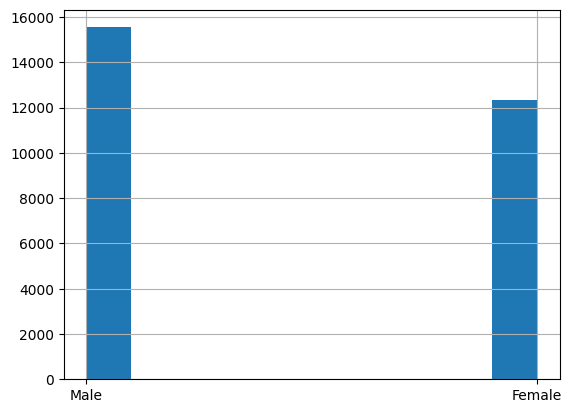

In [464]:
# Посмотрим на распределение по полу
depr_data.Gender.hist()

<Axes: >

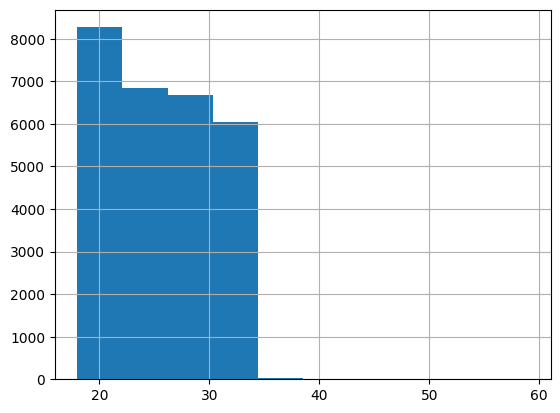

In [465]:
# Посмотрим на распределение по возрасту
depr_data.Age.hist()

In [466]:
# Проверяем на данные на выбросы
depr_data.isna().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

<Axes: >

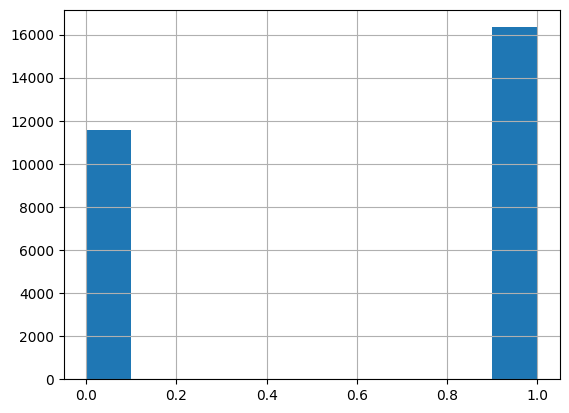

In [467]:
# Данные достаточно сбалансированы по таргету
depr_data.Depression.hist()

In [468]:
# Заполняем пустые значения 
depr_data['Financial Stress'].fillna(depr_data['Financial Stress'].median(), inplace=True)

In [469]:
# Подготавливаем данные для визуализации корреляционной матрицы
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.filterwarnings('ignore')

categorical_depr_transformer = OneHotEncoder(sparse=False)
numerical_depr_transformer = StandardScaler()

ohe_depr = OneHotEncoder(sparse=False)
scaler_depr = StandardScaler()

depr_categorical_features = ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
depr_numeric_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

depr_categorical_data = depr_data[depr_categorical_features]

depr_encoded_data = ohe_depr.fit_transform(depr_categorical_data)

depr_encoded_columns = ohe_depr.get_feature_names_out(depr_categorical_features)
depr_encoded_df = pd.DataFrame(depr_encoded_data, columns=depr_encoded_columns)

depr_numeric_data = depr_data[depr_numeric_features]

depr_scaled_data = scaler_depr.fit_transform(depr_numeric_data)

depr_scaled_columns = scaler_depr.get_feature_names_out(depr_numeric_features)
depr_scaled_df = pd.DataFrame(depr_scaled_data, columns=depr_scaled_columns)

# Версия датасета для корреляционной матрицы
depr_data_final = pd.concat([depr_scaled_df, depr_encoded_df, depr_data['Depression']], axis=1)

In [470]:
# Видно сильное влияние на депрессию со стороны проблем на работе и учебе, а также от мыслей к суициду и финансового положения
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(100, 100))
sns.heatmap(depr_data_final.corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [471]:
# Разбиение выборки на тестовую и тренировочную
from sklearn.model_selection import train_test_split

train_depr_X, test_depr_X, train_depr_y, test_depr_y = train_test_split(depr_data.drop(['Depression', 'id'], axis=1), depr_data['Depression'], test_size=0.1, shuffle=True, random_state=52, stratify=depr_data['Depression'])

# EDA + Предобработка данных (taxi price dataset)

In [472]:
# Считываем данные
taxi_dataset = pd.read_csv('./taxi_trip_pricing_dataset.csv')

In [473]:
# Смотрим на наличие NaN значений
taxi_dataset.isna().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

<Axes: >

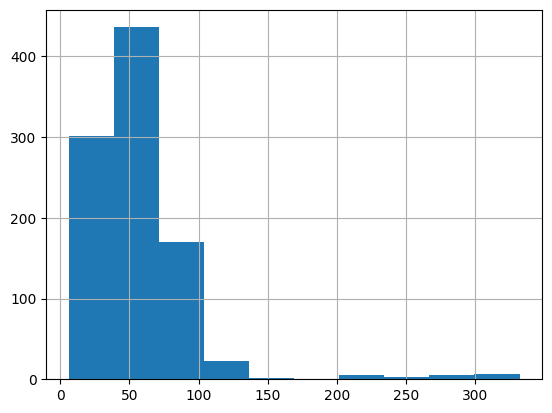

In [474]:
# Распредление по таргету
taxi_dataset.Trip_Price.hist()

In [475]:
# Общая инфа про таргет
taxi_dataset.Trip_Price.describe()

count    951.000000
mean      56.874773
std       40.469791
min        6.126900
25%       33.742650
50%       50.074500
75%       69.099350
max      332.043689
Name: Trip_Price, dtype: float64

In [476]:
# Заполняем пропуски

columns_to_filna = taxi_dataset.columns[taxi_dataset.isna().sum() > 0]
for column in columns_to_filna:
    if taxi_dataset[column].dtype == 'float64':
        taxi_dataset[column].fillna(value=taxi_dataset[column].median(), inplace=True)
    else:
        taxi_dataset[column].fillna(value=taxi_dataset[column].mode()[0], inplace=True)

In [477]:
# Подготавливаем данные для визуализации корреляционной матрицы
ohe_taxi = OneHotEncoder(sparse=False)
scaler_taxi = StandardScaler()

taxi_categorical_features = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
taxi_numeric_features = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
taxi_categorical_data = taxi_dataset[taxi_categorical_features]

taxi_encoded_data = ohe_taxi.fit_transform(taxi_categorical_data)

taxi_encoded_columns = ohe_taxi.get_feature_names_out(taxi_categorical_features)
taxi_encoded_df = pd.DataFrame(taxi_encoded_data, columns=taxi_encoded_columns)

taxi_numeric_data = taxi_dataset[taxi_numeric_features]

taxi_scaled_data = scaler_taxi.fit_transform(taxi_numeric_data)

taxi_scaled_columns = scaler_taxi.get_feature_names_out(taxi_numeric_features)
taxi_scaled_df = pd.DataFrame(taxi_scaled_data, columns=taxi_scaled_columns)

# Версия датасета для корреляционной матрицы
taxi_data_final = pd.concat([taxi_scaled_df, taxi_encoded_df, taxi_dataset['Trip_Price']], axis=1)

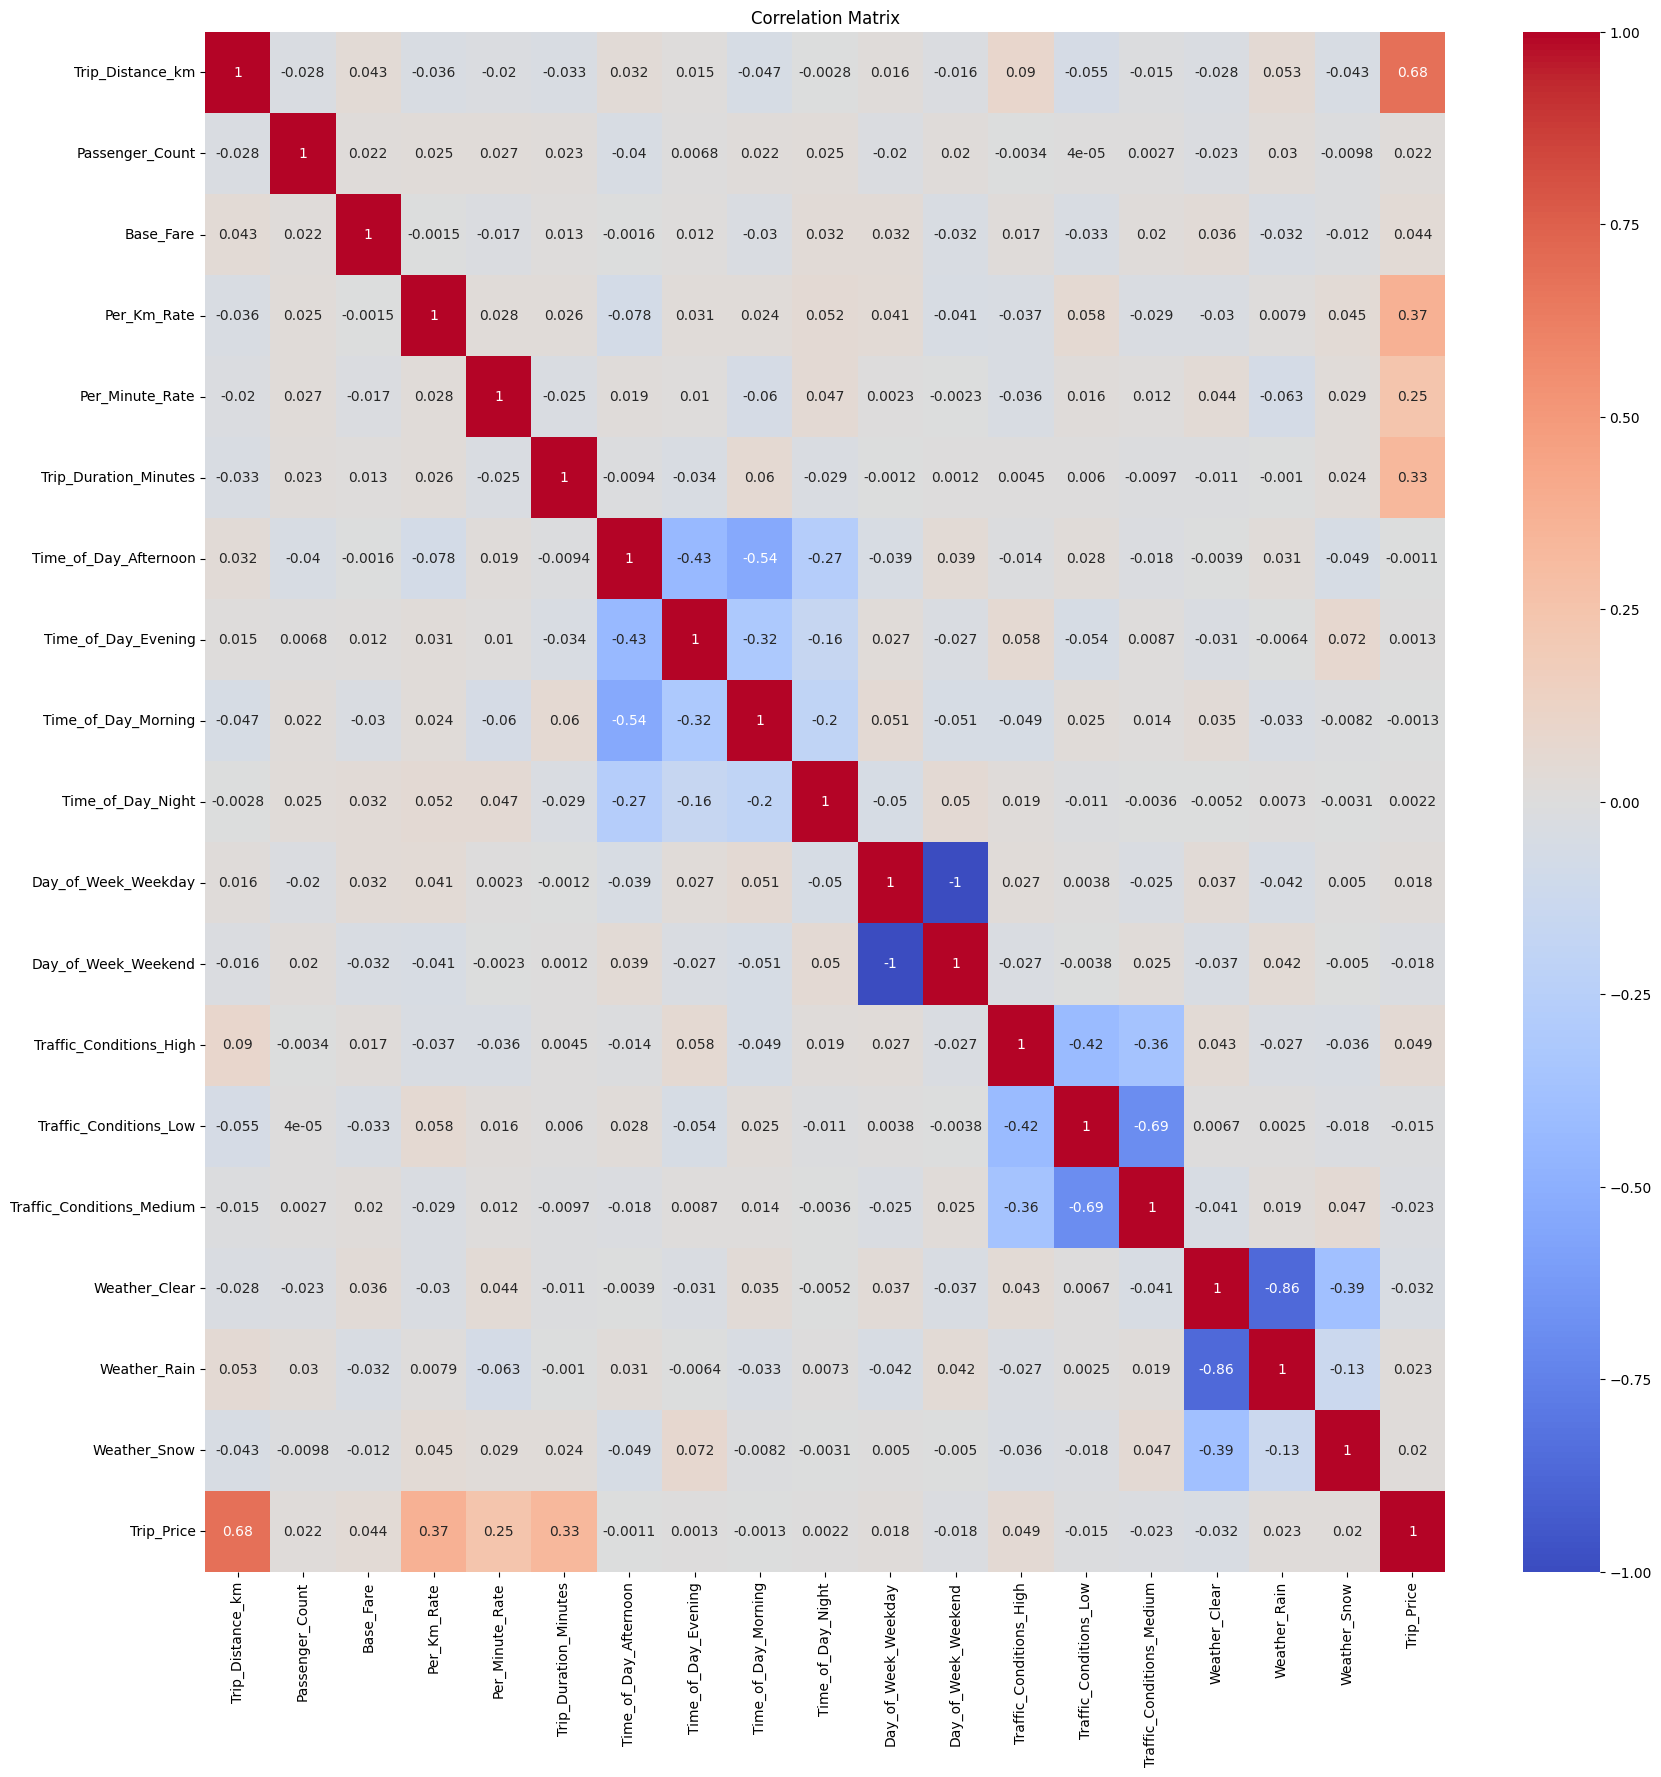

In [478]:
# Видна сильное влияние от расстояния поездки, длительности и соотвествующих коэфицентов за километр и минуту поездки на конечную стоимость

plt.figure(figsize=(20, 20))
sns.heatmap(taxi_data_final.corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [479]:
# Разбиение выборок на тестовую и тренировочную
from sklearn.model_selection import train_test_split

train_taxi_X, test_taxi_X, train_taxi_y, test_taxi_y = train_test_split(taxi_dataset.drop('Trip_Price', axis=1), taxi_dataset['Trip_Price'], test_size=0.1, shuffle=True, random_state=52)

# 1. KNN

# Classification baseline

In [480]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


categorical_transformer = OneHotEncoder(sparse=True)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=2))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn KNN Baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn KNN Baseline ROC_AUC metric is: 0.6777636841999474


# Classification improved 
1) numerical features standartizing
2) n_neighbors hyperparameter increasing

In [481]:
categorical_transformer = OneHotEncoder(sparse=True)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=12))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn KNN Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn KNN Improved ROC_AUC metric is: 0.8351725805035392


Вывод: стандартизация входных данных, а также подобранный гиперпараметр количества ближайших соседей улучшает качество бейзлайна

# Regression baseline

In [482]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

categorical_transformer = OneHotEncoder(sparse=True)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsRegressor(n_neighbors=2))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Sklearn KNN Baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn KNN Baseline MAE metric is: 33.88045410625985


# Regression improved

1) numerical features standartizing
2) n_neighbors hyperparameter increasing

In [483]:
categorical_transformer = OneHotEncoder(sparse=True)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
        ('num', numerical_transformer, taxi_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsRegressor(n_neighbors=10))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Sklearn KNN Improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn KNN Improved MAE metric is: 12.41417221665521


Вывод: стандартизация численных признаков имеет в задачи классификации бОльшее влияние, чем в задаче регрессии.
Лучшего значения метрики также удалось достичь с помощью подбора гиперпараметра числа ближайших соседей

# Custom KNN algorithms implementation

In [484]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Сохраняем данные как numpy-массивы
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        X_test = np.array(X)
        predictions = []

        for x in X_test:
            # Вычисляем расстояния до всех точек обучающего набора
            distances = np.linalg.norm(self.X_train - x, axis=1)

            # Индексы k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Среднее значение целевой переменной ближайших соседей
            nearest_values = self.y_train[nearest_indices]
            predictions.append(np.mean(nearest_values))

        return np.array(predictions)


class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Сохраняем данные как numpy-массивы
        self.X_train = np.array(X)
        self.y_train = np.array(y)

        return self

    def predict(self, X):
        X_test = np.array(X)
        predictions = []

        for x in X_test:
            # Вычисляем расстояния до всех точек обучающего набора
            distances = np.linalg.norm(self.X_train - x, axis=1)

            # Индексы k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Прогноз как наиболее частое значение (классификация)
            nearest_values = self.y_train[nearest_indices]
            predictions.append(np.bincount(nearest_values).argmax())

        return np.array(predictions)


# Custom classification baseline

In [485]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNNClassifier(n_neighbors=2))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Сustom KNN Baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Сustom KNN Baseline ROC_AUC metric is: 0.6677006756806793


# Custom classification improved

In [486]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNNClassifier(n_neighbors=12))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom KNN Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom KNN Improved ROC_AUC metric is: 0.8351725805035392


Выводы: 
1) Качество самописного классификатора совпадает с sklearn реализацией
2) Время работы самописного алгоритма оставляет желать лучшего


# Custom regression baseline

In [487]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNNRegressor(n_neighbors=2))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Сustom KNN Baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Сustom KNN Baseline MAE metric is: 33.356626152190486


# Custom regression improved
1) numeric features added
2) n_neighbors adjusted

In [488]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
        ('num', numerical_transformer, taxi_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNNRegressor(n_neighbors=10))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Сustom KNN Improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Сustom KNN Improved MAE metric is: 12.41417221665521


Выводы:
1) Самописная реализация KNNRegressor перфомит в точности одинаково с sklearn реализацией, бейзлайновая конфигурация в самописной версии чуть лучше

# 2. Linear Models

# Regression baseline

In [489]:
from sklearn.linear_model import LinearRegression

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Sklearn Linear baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn Linear baseline MAE metric is: 30.660045106259844


# Regression improved
1) Feature Engineering
2) hyperparameter tuning

In [490]:
# Для того, чтобы добавить новые фичи, скопируем имеющееся разбиение

train_taxi_X_cp = train_taxi_X.copy()
test_taxi_X_cp = test_taxi_X.copy()

In [491]:
# Сформируем новые фичи (загрузка из за времени суток, загрузка из за плохой погоды, базовая стоимость на основе коэфицентов и изначальной цены поездки, фактор пустой дороги и хорошей погоды, средняя цена на выходных и в будни)

def add_new_features(df, train_y, train_version_df=False, average_weekday=None, average_weekend=None):

    df['highload_time_of_day'] = (
        (df['Traffic_Conditions'] == 'High') &
        ((df['Time_of_Day'] == 'Evening') | (df['Time_of_Day'] == 'Morning'))
    )

    df['highload_bad_weather'] = (
        (df['Traffic_Conditions'] == 'High') &
        ((df['Weather'] == 'Rain') | (df['Weather'] == 'Snow'))
    )

    df['effective_cost'] = (
        (df['Base_Fare'] + df['Per_Km_Rate'] * df['Trip_Distance_km']) + (df['Per_Minute_Rate'] * df['Trip_Duration_Minutes'])
    )

    df['freeroad_good_weather'] = (
        (df['Traffic_Conditions'] == 'Low') |
        ((df['Traffic_Conditions'] == 'Medium') & (df['Weather'] == 'Clear'))
    )

    if train_version_df:
        
        df['Trip_Price'] = train_y
        average_dayofweek_prices = df.groupby('Day_of_Week').mean(1).Trip_Price
        average_weekday, average_weekend = average_dayofweek_prices[0], average_dayofweek_prices[1]

        df.loc[(df['Day_of_Week'] == 'Weekday'), 'average_day_of_week_price'] = average_weekday
        df.loc[(df['Day_of_Week'] == 'Weekend'), 'average_day_of_week_price'] = average_weekend
        df.drop('Trip_Price', axis=1, inplace=True)

        return average_weekday, average_weekend
    
    else:

        df.loc[(df['Day_of_Week'] == 'Weekday'), 'average_day_of_week_price'] = average_weekday
        df.loc[(df['Day_of_Week'] == 'Weekend'), 'average_day_of_week_price'] = average_weekend
    

    return None

avg_weekday, avg_weekend = add_new_features(train_taxi_X_cp, train_taxi_y, train_version_df=True)
add_new_features(test_taxi_X_cp, train_y=None, train_version_df=False, average_weekday=avg_weekday, average_weekend=avg_weekend)

In [492]:
from sklearn.linear_model import LinearRegression

taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Sklearn Linear improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn Linear improved MAE metric is: 10.421879765351118


Выводы: с помощью подбора новых фичей, получилось добиться лучшего качества, чем на KNN

# Classification baseline

In [493]:
from sklearn.linear_model import LogisticRegression

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn Linear Logistic Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn Linear Logistic Improved ROC_AUC metric is: 0.7753610347953863


# Classification improved
1) numeric features added
2) hyperparameter tuning

In [494]:
from sklearn.linear_model import LogisticRegression

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga'))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn Linear Logistic Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn Linear Logistic Improved ROC_AUC metric is: 0.8472701950450083


Выводы: перебор гиперпараметров и добавление численных фичей дает прирост в качестве относительно бейзлайна, а также алгоритма KNN

# Custom Linear algorithms implementation

In [495]:
class CustomLogisticRegression(BaseEstimator, ClassifierMixin):

    def __init__(self, max_iter=5e3, lr=0.04, tol=0.001, l1_coef=0.1):


        '''
        max_iter – максимальное количеств
        '''

        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.l1_coef = l1_coef
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train):

        '''
        Обучение модели.

        X_train – матрица объектов для обучения
        y_train – ответы на объектах для обучения

        '''


        n, m = X_train.shape
        y_train = y_train.to_numpy().reshape(-1, 1)

        self.weights = np.zeros((m, 1))
        self.bias = np.mean(y_train)

        n_iter = 0
        gradient_norm = np.inf

        while n_iter < self.max_iter and gradient_norm > self.tol:

            dJdw, dJdb = self.grads(X_train, y_train)

            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))

            self.weights = self.weights - self.lr * dJdw
            self.bias = self.bias - self.lr * dJdb

            n_iter += 1

        return self

    def predict(self, X):

        '''
        Метод возвращает предсказанную метку класса на объектах X
        '''
        return list(map(lambda x: int(x[0] > 0.5764479042420024), self.predict_proba(X)))


    def predict_proba(self, X):

        '''
        Метод возвращает вероятность класса 1 на объектах X
        '''

        return LogisticRegression.sigmoid(np.dot(X, self.weights) + self.bias)

    def grads(self, X, y):

        '''
        Рассчёт градиентов
        '''


        y_hat = self.predict_proba(X)

        dJdw = np.mean(X * (y_hat - y) + self.l1_coef * np.sign(self.weights.T), axis=0, keepdims=True).T
        dJdb = np.mean(y_hat - y)

        return dJdw, dJdb

    @staticmethod
    def sigmoid(x):
        '''
        Сигмоида от x
        '''

        return 1 / (1 + np.exp(-x))
    


class CustomLinearRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=5000, lr=0.04, tol=0.001, l1_coef=0.1):
        '''
        max_iter – максимальное количество итераций
        lr – скорость обучения (learning rate)
        tol – порог для нормы градиента
        l1_coef – коэффициент L1-регуляризации
        '''
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.l1_coef = l1_coef
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train):
        '''
        Обучение модели.
        X_train – матрица объектов для обучения
        y_train – ответы на объектах для обучения
        '''
        n, m = X_train.shape
        y_train = y_train.to_numpy().reshape(-1, 1)

        # Инициализация весов
        self.weights = np.zeros((m, 1))
        self.bias = np.mean(y_train)

        n_iter = 0
        gradient_norm = np.inf

        while n_iter < self.max_iter and gradient_norm > self.tol:
            dJdw, dJdb = self.grads(X_train, y_train)

            # Норма градиента для контроля сходимости
            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))

            # Обновление весов и смещения
            self.weights -= self.lr * dJdw
            self.bias -= self.lr * dJdb

            n_iter += 1

        return self

    def predict(self, X):
        '''
        Метод возвращает предсказания (непрерывные значения) на объектах X
        '''
        return np.dot(X, self.weights) + self.bias

    def grads(self, X, y):
        '''
        Рассчёт градиентов
        '''
        y_hat = self.predict(X)

        # Градиенты для весов и смещения
        
        dJdw = np.mean(X * (y_hat - y) + self.l1_coef * np.sign(self.weights.T), axis=0, keepdims=True).T
        dJdb = np.mean(y_hat - y)

        return dJdw, dJdb


# Custom Regression baseline

In [496]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomLinearRegression())
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Custom Linear baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom Linear baseline MAE metric is: 30.69516174122698


# Custom Regression improved
1) Добавление новых фичей

In [497]:
from sklearn.linear_model import LinearRegression

taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomLinearRegression())
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Custom Linear improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom Linear improved MAE metric is: 10.34906743612127


Выводы: Удалось получить хороший результат с помощью генерации новых фичей

# Custom Classification baseline

In [498]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomLogisticRegression())
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom Linear Logistic baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

AttributeError: type object 'LogisticRegression' has no attribute 'sigmoid'

# Custom Classification Improved

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomLogisticRegression(l1_coef=0.05))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom Linear Logistic Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom Linear Logistic Improved ROC_AUC metric is: 0.8268434699540554


Выводы: самописная реализация не содержит солверов, как у модели из коробки, что не позволяет достичь желаемого качества

# 3. Decision Tree

# Regression baseline

In [ ]:
from sklearn.tree import DecisionTreeRegressor

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor(criterion='squared_error', max_depth=5, random_state=42))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Sklearn RegressionTree baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn RegressionTree baseline MAE metric is: 30.329818062395507


# Regression improved
1) Переиспользуем новые фичи, которые вывели на линейной модели
2) Также подбираем гиперпараметры

In [ ]:
taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor(criterion='absolute_error', max_depth=6, min_samples_leaf=5, random_state=42))
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Sklearn DecisionTree improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn DecisionTree improved MAE metric is: 6.231140316079474


Выводы: получилось достичь лучшего качества, чем на линейной модели, потому что деревья могут улавлвивать нелинейные зависимости в данных

# Classification baseline

In [ ]:
from sklearn.tree import DecisionTreeClassifier

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn DecisionTreeClassifier baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn DecisionTreeClassifier baseline ROC_AUC metric is: 0.7782250343552999


# Classification improved
1) Подбор гиперпараметров

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn DecisionTreeClassifier Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn DecisionTreeClassifier Improved ROC_AUC metric is: 0.830043088263764


Выводы: не получилось достичь лучшего качества, чем на линейной модели в классификации

# Custom DecisionTree implementation

In [ ]:
class CustomDecisionTreeClassifier:

    def __init__(self, max_depth=None, max_features=None, min_samples_split=2, min_leaf_samples=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_split = min_samples_split  # Минимальное количество объектов для разбиения
        self.min_leaf_samples = min_leaf_samples
        self._node = {
            'left': None,
            'right': None,
            'feature': None,
            'threshold': None,
            'depth': 0,
            'classes_proba': None
        }
        self.tree = None  # Словарь для хранения дерева
        self.classes = None  # Список меток классов

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = {'root': self._node.copy()}  # Создаем корневой узел
        self._build_tree(self.tree['root'], X, y)  # Рекурсивно строим дерево
        return self

    def predict_proba(self, X):
        proba_preds = []
        for x in X:
            preds_for_x = self._get_predict(self.tree['root'], x)  # Рекурсивно ищем лист
            proba_preds.append(preds_for_x)
        return np.array(proba_preds)

    def predict(self, X):
        proba_preds = self.predict_proba(X)
        preds = proba_preds.argmax(axis=1).reshape(-1, 1)
        return preds

    def get_best_split(self, X, y):
        best_j = None
        best_t = None
        best_left_ids = None
        best_right_ids = None
        best_Q = float('-inf')

        for i in range(X.shape[1]):
            unique_features = np.unique(X[:, i])
            for j in range(len(unique_features) - 1):
                cur_threshold = (unique_features[j] + unique_features[j + 1]) / 2
                left_indexes = X[:, i] < cur_threshold
                left_children_y = y[left_indexes]
                right_children_y = y[~left_indexes]

                # Условие минимального числа объектов в листе
                if len(left_children_y) < self.min_samples_split or len(right_children_y) < self.min_samples_split:
                    continue

                cur_Q = self.calc_Q(y, left_children_y, right_children_y)
                if cur_Q > best_Q:
                    best_Q = cur_Q
                    best_j = i
                    best_t = cur_threshold
                    best_left_ids = left_indexes
                    best_right_ids = ~left_indexes

        return best_j, best_t, best_left_ids, best_right_ids

    def calc_Q(self, y, y_left, y_right):
        Q = self.gini(y) - ((len(y_left) / len(y)) * self.gini(y_left) + (len(y_right) / len(y)) * self.gini(y_right))
        return Q

    def gini(self, y):
        H = 0
        for label in self.classes:
            prob = (y == label).sum() / len(y)
            H += prob * (1 - prob)
        return H

    def _build_tree(self, curr_node, X, y):
        # Условие завершения: достигнута максимальная глубина
        if curr_node['depth'] == self.max_depth:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        # Условие завершения: меньше минимального числа объектов для разбиения
        if len(y) < self.min_samples_split:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        # Условие завершения: все метки одинаковы
        if len(np.unique(y)) == 1:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        # Поиск лучшего разбиения
        j, t, left_ids, right_ids = self.get_best_split(X, y)

        # Если не найдено разбиение
        if j is None or t is None:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        # Сохраняем информацию о разбиении
        curr_node['feature'] = j
        curr_node['threshold'] = t

        # Создаем узлы для левого и правого поддеревьев
        left = self._node.copy()
        right = self._node.copy()
        left['depth'] = curr_node['depth'] + 1
        right['depth'] = curr_node['depth'] + 1

        curr_node['left'] = left
        curr_node['right'] = right

        # Рекурсивно строим левое и правое поддеревья
        self._build_tree(left, X[left_ids], y[left_ids])
        self._build_tree(right, X[right_ids], y[right_ids])

    def _get_predict(self, node, x):
        if node['threshold'] is None:  # Если узел — лист
            return [node['classes_proba'][c] for c in self.classes]

        if x[node['feature']] <= node['threshold']:
            return self._get_predict(node['left'], x)
        else:
            return self._get_predict(node['right'], x)





    
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self._node = {
            'left': None,
            'right': None,
            'feature': None,
            'threshold': None,
            'depth': 0,
            'value': None  # Среднее значение целевой переменной для узла
        }
        self.tree = None  # Словарь для хранения построенного дерева

    def fit(self, X, y):
        self.tree = {'root': self._node.copy()}  # Создаем корневой узел
        self._build_tree(self.tree['root'], X, y)  # Рекурсивно строим дерево
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            pred = self._get_prediction(self.tree['root'], x)  # Рекурсивно находим прогноз для объекта
            predictions.append(pred)
        return np.array(predictions)

    def get_best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_left_ids = None
        best_right_ids = None
        best_impurity = float('inf')  # Для регрессии минимизируем impurity

        for i in range(X.shape[1]):
            unique_values = np.unique(X[:, i])
            for j in range(len(unique_values) - 1):
                threshold = (unique_values[j] + unique_values[j + 1]) / 2
                left_ids = X[:, i] < threshold
                right_ids = ~left_ids

                if len(y[left_ids]) < self.min_samples_split or len(y[right_ids]) < self.min_samples_split:
                    continue

                impurity = self.calc_impurity(y, y[left_ids], y[right_ids])
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = i
                    best_threshold = threshold
                    best_left_ids = left_ids
                    best_right_ids = right_ids

        return best_feature, best_threshold, best_left_ids, best_right_ids

    def calc_impurity(self, y, y_left, y_right):
        # Снижение дисперсии
        def variance(data):
            return np.var(data) * len(data)

        left_impurity = variance(y_left)
        right_impurity = variance(y_right)
        total_impurity = (left_impurity + right_impurity) / len(y)
        return total_impurity

    def _build_tree(self, curr_node, X, y):
        # Остановка при достижении максимальной глубины
        if curr_node['depth'] == self.max_depth or len(y) < self.min_samples_split:
            curr_node['value'] = np.mean(y)  # Сохраняем среднее значение целевой переменной
            return

        if np.var(y) == 0:  # Если дисперсия равна нулю, то все значения одинаковы
            curr_node['value'] = np.mean(y)
            return

        feature, threshold, left_ids, right_ids = self.get_best_split(X, y)

        if feature is None:  # Если нет подходящего разбиения
            curr_node['value'] = np.mean(y)
            return

        # Сохраняем текущий узел
        curr_node['feature'] = feature
        curr_node['threshold'] = threshold

        # Создаем узлы для левого и правого поддеревьев
        left = self._node.copy()
        right = self._node.copy()
        left['depth'] = curr_node['depth'] + 1
        right['depth'] = curr_node['depth'] + 1

        curr_node['left'] = left
        curr_node['right'] = right

        # Рекурсивно строим левое и правое поддеревья
        self._build_tree(left, X[left_ids], y[left_ids])
        self._build_tree(right, X[right_ids], y[right_ids])

    def _get_prediction(self, node, x):
        if node['threshold'] is None:  # Лист дерева
            return node['value']

        if x[node['feature']] <= node['threshold']:
            return self._get_prediction(node['left'], x)
        else:
            return self._get_prediction(node['right'], x)


# Custom Classification baseline

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomDecisionTreeClassifier(max_depth=3))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom DecisionTreeClassifier baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom DecisionTreeClassifier baseline ROC_AUC metric is: 0.7782250343552999


# Custom Classification improved
1) Переиспользуем параметры из sklearn реализации

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomDecisionTreeClassifier(max_depth=8))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom DecisionTreeClassifier Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom DecisionTreeClassifier Improved ROC_AUC metric is: 0.8297370907117445


Выводы: удалось достичь такого же качетсва классификации, как и в sklearn реализации, но время работы алгоритма немного медленнее

# Custom Regression baseline

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomDecisionTreeRegressor(max_depth=5))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Сustom RegressionTree baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Сustom RegressionTree baseline MAE metric is: 30.329818062395496


# Custom Regression improved
1) Переиспользуем параметры из предыдущего шага на готовой реализации дерева

In [ ]:
taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomDecisionTreeRegressor(max_depth=6))
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Custom DecisionTree improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom DecisionTree improved MAE metric is: 7.824141421731417


Выводы: не получилось достичь такого же качества, потому что не имплементированы тонкости и оптимизации алгоритма из коробки

# 4. Random Forest

# Classification baseline

In [ ]:
from sklearn.ensemble import RandomForestClassifier
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn RandomForest baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn RandomForest baseline ROC_AUC metric is: 0.7782250343552999


# Classification improved
1) Подбор гиперпараметров

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=10))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn RandomForest Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn RandomForest Improved ROC_AUC metric is: 0.8273750646641326


# Regression baseline

In [ ]:
from sklearn.ensemble import RandomForestRegressor

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Sklearn RandomForest baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn RandomForest baseline MAE metric is: 32.195152604376666


# Regression improved
1) Подбор гиперпараметров
2) Использование новых фичей

In [ ]:
taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4))
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Sklearn RandomForest improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn RandomForest improved MAE metric is: 7.556527083063669


Выводы: не получилось сделать лучшее качество, чем на обычном решающем дереве

# Custom RandomForest implementation

In [ ]:
class CustomRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        y = y.to_numpy().reshape(-1, 1)
        np.random.seed(self.random_state)
        self.trees = []
        self.feature_indices = []

        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[sample_indices]
            y_sample = y[sample_indices]

            # Subset of features
            if self.max_features is None:
                max_features = n_features
            else:
                max_features = min(n_features, self.max_features)
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Train a tree
            tree = CustomDecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X):
        # Aggregate predictions from all trees (majority voting)
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, self.feature_indices[i]]).flatten()

        # Majority voting
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
        return final_predictions

    def predict_proba(self, X):
        # Aggregate probabilities from all trees
        predictions = np.zeros((X.shape[0], len(self.trees), len(np.unique(self.trees[0].classes))))
        for i, tree in enumerate(self.trees):
            predictions[:, i, :] = tree.predict_proba(X[:, self.feature_indices[i]])
        return np.mean(predictions, axis=1)

class CustomRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        y = y.to_numpy().reshape(-1, 1)
        np.random.seed(self.random_state)
        self.trees = []
        self.feature_indices = []

        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[sample_indices]
            y_sample = y[sample_indices]

            # Subset of features
            if self.max_features is None:
                max_features = n_features
            else:
                max_features = min(n_features, self.max_features)
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Train a tree
            tree = CustomDecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X):
        # Aggregate predictions from all trees
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, self.feature_indices[i]])
        return np.mean(predictions, axis=1)


# Custom classification baseline

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomRandomForestClassifier(n_estimators=100, max_depth=5))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom RandomForest baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom RandomForest baseline ROC_AUC metric is: 0.776909800279074


# Custom classification improved
1) Переиспользуем параметры из sklearn версии

In [500]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomRandomForestClassifier(n_estimators=200, max_depth=15))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom RandomForest Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom RandomForest Improved ROC_AUC metric is: 0.8394242802842364


Выводы: достигли таких же результатов, что и в sklearn реализации, получилось немного лучше на improved версии

# Custom regression baseline

In [502]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomRandomForestRegressor(n_estimators=100, max_depth=10))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Custom RandomForest baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom RandomForest baseline MAE metric is: 31.653176904062143


# Custom regression improved
1) Переиспользуем параметры из sklearn версии

In [503]:
taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomRandomForestRegressor(n_estimators=100, max_depth=10))
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Custom RandomForest improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom RandomForest improved MAE metric is: 7.333322137851406


Выводы: получилось достичь такого же качества как и в sklearn

# 5. Gradient Boosting

# Regression baseline

In [504]:
from sklearn.ensemble import GradientBoostingRegressor

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Sklearn Boosting baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn Boosting baseline MAE metric is: 31.06332074818826


# Regression improved

In [529]:
taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_leaf_nodes=10, max_depth=2))
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Sklearn Boosting improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Sklearn Boosting improved MAE metric is: 6.826480847995353


# Classification baseline

In [530]:
from sklearn.ensemble import GradientBoostingClassifier
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_leaf_nodes=10, max_depth=2))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Sklearn Boosting baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Sklearn Boosting baseline ROC_AUC metric is: 0.774982571098809


# Classification improved

In [536]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=200, learning_rate=0.15, max_depth=3))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom Boosting Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom Boosting Improved ROC_AUC metric is: 0.8398000992310125


# Custom Boosting implementation

In [546]:
class CustomGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, random_state=None):
        self.n_estimators = n_estimators  # Количество деревьев
        self.learning_rate = learning_rate  # Скорость обучения
        self.max_depth = max_depth  # Максимальная глубина деревьев
        self.min_samples_split = min_samples_split  # Минимальное количество объектов для разбиения
        self.random_state = random_state  # Для воспроизводимости
        self.trees = []  # Список деревьев

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []

        # Начальное предсказание - среднее значение y
        y_pred = np.full(y.shape, np.mean(y))

        for _ in range(self.n_estimators):
            # Остатки (градиенты)
            residuals = y - y_pred

            # Обучаем дерево на остатки
            tree = CustomDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Обновляем предсказания
            y_pred += self.learning_rate * tree.predict(X)

        return self

    def predict(self, X):
        # Начальное предсказание
        y_pred = np.zeros(X.shape[0])

        # Суммируем предсказания всех деревьев
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)

        return y_pred

class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees = []  # Список деревьев для каждого класса
        self.classes = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []

        # Преобразуем y в one-hot encoding
        self.classes = np.unique(y)
        y_onehot = np.eye(len(self.classes))[y]

        # Начальное предсказание - среднее значение y для каждого класса
        y_pred = np.full(y_onehot.shape, np.mean(y_onehot, axis=0))

        for _ in range(self.n_estimators):
            # Остатки (градиенты)
            residuals = y_onehot - self._softmax(y_pred)

            # Создаем деревья для каждого класса
            class_trees = []
            for c in range(len(self.classes)):
                tree = CustomDecisionTreeRegressor(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split
                )
                tree.fit(X, residuals[:, c])  # Обучение дерева на остатки текущего класса
                class_trees.append(tree)

            self.trees.append(class_trees)

            # Обновляем предсказания
            for c, tree in enumerate(class_trees):
                y_pred[:, c] += self.learning_rate * tree.predict(X)

        return self

    def predict_proba(self, X):
        # Начальное предсказание
        y_pred = np.zeros((X.shape[0], len(self.classes)))

        # Суммируем предсказания всех деревьев
        for class_trees in self.trees:
            for c, tree in enumerate(class_trees):
                y_pred[:, c] += self.learning_rate * tree.predict(X)

        # Преобразуем в вероятности с помощью softmax
        return self._softmax(y_pred)

    def predict(self, X):
        # Получаем вероятности
        proba = self.predict_proba(X)
        # Выбираем класс с максимальной вероятностью
        return np.argmax(proba, axis=1)

    @staticmethod
    def _softmax(logits):
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)


# Custom regression baseline

In [538]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
])

pipeline.fit(train_taxi_X, train_taxi_y)
y_pred = pipeline.predict(test_taxi_X)

print(f"Custom Boosting baseline MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom Boosting baseline MAE metric is: 59.60031416277675


# Custom regression improved

In [541]:
taxi_categorical_features_added = ['highload_time_of_day', 'highload_bad_weather', 'freeroad_good_weather']
taxi_numeric_features_added = ['effective_cost', 'average_day_of_week_price']

categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, taxi_categorical_features_added),
        ('num', numerical_transformer, taxi_numeric_features_added)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2))
])

pipeline.fit(train_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added], train_taxi_y)
y_pred = pipeline.predict(test_taxi_X_cp[taxi_categorical_features_added + taxi_numeric_features_added])

print(f"Custom Boosting improved MAE metric is: {mean_absolute_error(test_taxi_y, y_pred)}")

Custom Boosting improved MAE metric is: 56.406474166216555


# Custom classification baseline

In [547]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomGradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=2))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom Boosting baseline ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom Boosting baseline ROC_AUC metric is: 0.7781525682107421


# Custom classification improved

In [548]:
categorical_transformer = OneHotEncoder(sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, depr_categorical_features),
        ('num', numerical_transformer, depr_numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomGradientBoostingClassifier(n_estimators=200, learning_rate=0.15, max_depth=3))
])

pipeline.fit(train_depr_X, train_depr_y)
y_pred = pipeline.predict(test_depr_X)

print(f"Custom Boosting Improved ROC_AUC metric is: {roc_auc_score(test_depr_y, y_pred)}")

Custom Boosting Improved ROC_AUC metric is: 0.8413327317409118


### Таблица 1 Метрика качества на тестовом наборе данных

| **Алгоритм**          | **Задача**        | **Бейзлайн** | **Улучшенный бейзлайн** | **Самостоятельная имплементация алгоритма** |
|------------------------|-------------------|-------------|-------------------------|---------------------------------------------|
| **KNN**               | классификация     |    0.67         |         0.835                |           0.835                                  |
|                        | регрессия        |      33.8       |         12.41                |              12.41                               |
| **Линейные модели**    | классификация     |     0.77        |         0.847                |              0.82                               |
|                        | регрессия        |     30.66        |         10.41                |              10.34                               |
| **Решающее дерево**    | классификация     |    0.77         |       0.83                  |               0.83                              |
|                        | регрессия        |     30.32        |       6.23                  |              7.82                              |
| **Случайный лес**      | классификация     |    0.77         |       0.82                  |              0.84                               |
|                        | регрессия        |     32.1        |        7.55                 |               7.33                              |
| **Градиентный бустинг**| классификация     |    0.77         |       0.834                  |              0.84                               |
|                        | регрессия        |     31.06        |       6.82                  |              56.2                               |
